In [1]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2023-05-21 16:18:36.464565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/ML/data'
TRAIN_BENIGH_PATH = '/content/drive/MyDrive/ML/data/train/benign'
TRAIN_MALIGNANT_PATH = '/content/drive/MyDrive/ML/data/train/malignant'
TEST_BENIGH_PATH = '/content/drive/MyDrive/ML/data/test/benign'
TEST_MALIGNANT_PATH = '/content/drive/MyDrive/ML/data/test/malignant'



In [2]:
TRAIN_BENIGH_PATH = '/Users/wangruihan/Desktop/Machine Learning & Predictive Analysis/Jieyu_final/data/train/benign'
TRAIN_MALIGNANT_PATH = '/Users/wangruihan/Desktop/Machine Learning & Predictive Analysis/Jieyu_final/data/train/malignant'
TEST_BENIGH_PATH = '/Users/wangruihan/Desktop/Machine Learning & Predictive Analysis/Jieyu_final/data/test/benign'
TEST_MALIGNANT_PATH = '/Users/wangruihan/Desktop/Machine Learning & Predictive Analysis/Jieyu_final/data/test/malignant'


In [3]:
%%time
train_benign_images = glob.glob(f"{TRAIN_BENIGH_PATH}**/*.jpg")
train_malignant_images = glob.glob(f"{TRAIN_MALIGNANT_PATH}**/*.jpg")
train_images = train_benign_images + train_malignant_images
test_benign_images = glob.glob(f"{TEST_BENIGH_PATH}**/*.jpg")
test_malignant_images = glob.glob(f"{TEST_MALIGNANT_PATH}**/*.jpg")
test_images = test_benign_images + test_malignant_images


CPU times: user 8.87 ms, sys: 8.21 ms, total: 17.1 ms
Wall time: 27.4 ms


In [4]:
# Get train & test set sizes
train_benign_images_size = len(train_benign_images)
train_malignant_images_size = len(train_malignant_images)
train_size = len(train_images)
test_benign_images_size = len(test_benign_images)
test_malignant_images_size = len(test_malignant_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train benign samples count:\t\t{train_benign_images_size}')
print(f'train malignant count:\t\t{train_malignant_images_size}')
print(f'train count:\t\t{train_size}')
print(f'test benign samples count:\t\t{test_benign_images_size}')
print(f'test malignant count:\t\t{test_malignant_images_size}')
print(f'test count:\t\t{test_size}')
print(f'total count:\t\t{total}')



train benign samples count:		1440
train malignant count:		1197
train count:		2637
test benign samples count:		360
test malignant count:		300
test count:		660
total count:		3297


In [5]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 66
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [6]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    
    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [7]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))


In [8]:
train_df.head(5)


,image_path,label,label_encoded
0,/Users/wangruihan/Desktop/Machine Learning & P...,benign,1
1,/Users/wangruihan/Desktop/Machine Learning & P...,benign,1
2,/Users/wangruihan/Desktop/Machine Learning & P...,malignant,0
3,/Users/wangruihan/Desktop/Machine Learning & P...,benign,1
4,/Users/wangruihan/Desktop/Machine Learning & P...,benign,1


In [9]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

Exploratory Data Analysis

View multiple random samples¶


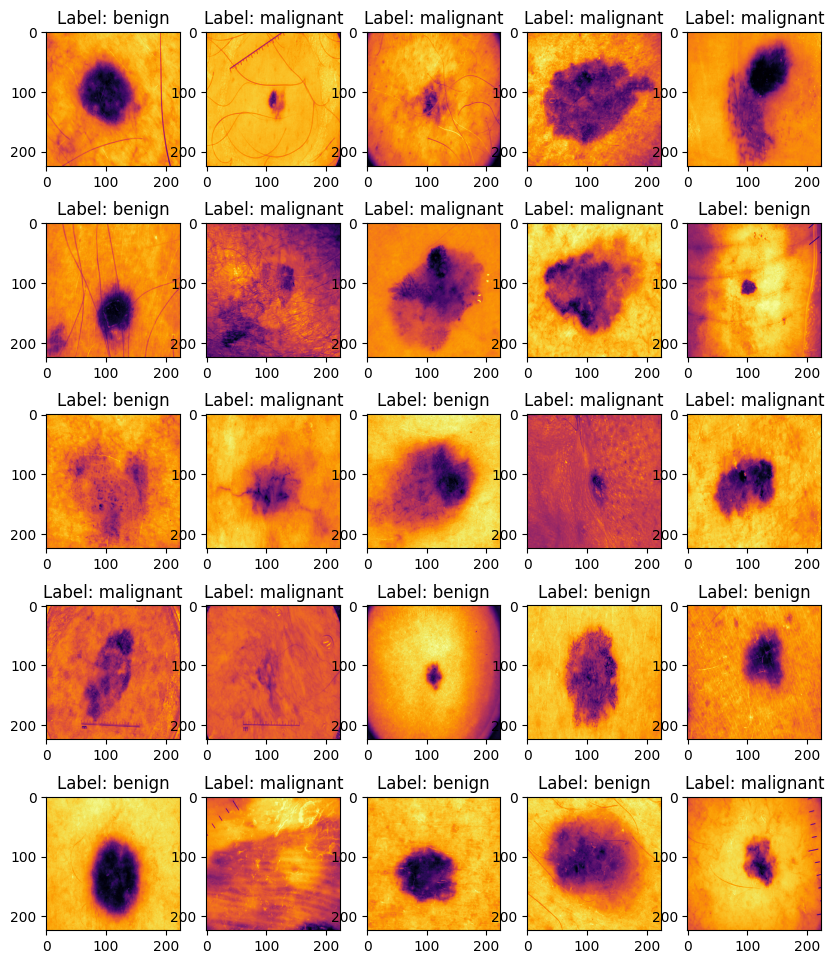

In [10]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(16, 12)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)
    
    return

view_mulitiple_samples(train_df, _load, 
                       count=25, color_map='inferno', 
                       fig_size=(10, 12))

View Train Labels Distribution


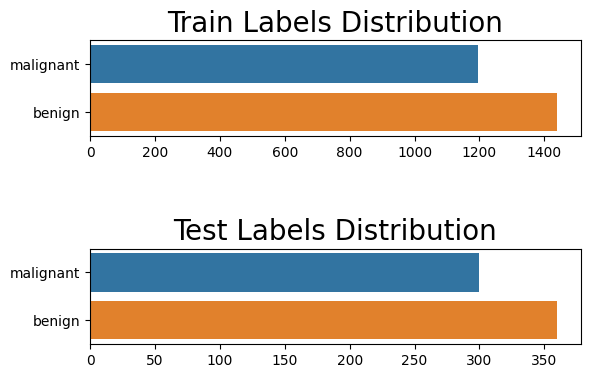

In [11]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 5))
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

# Data Preprocessing


In [12]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [13]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

In [14]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

In [15]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
#view_sample(sample_image, sample_label, color_map='inferno')

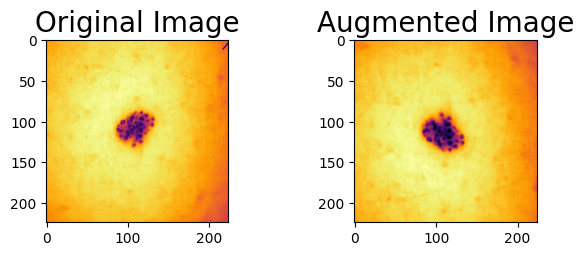

In [16]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(image, cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(augmentation_layer(image), cmap='inferno');

In [17]:
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [18]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_new_df, _load, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

# 1st Model :Convolutional Neural Network (CNN)


In [19]:
def cnn_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='cnn_sequential_model')
    
    return cnn_sequential


In [20]:
# Generate Model
model_cnn = cnn_model()

# Generate Summary of the Model
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23328)             0         
                                                                 
 dropout (Dropout)           (None, 23328)    

/opt/anaconda3/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [21]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):

    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [22]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [23]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_cnn.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

cnn_history = train_model(
    model_cnn, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training cnn_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------


2023-05-21 16:20:15.884914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2241]
	 [[{{node Placeholder/_0}}]]
2023-05-21 16:20:15.885254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2241,2]
	 [[{{node Placeholder/_1}}]]


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.6444

2023-05-21 16:20:46.343313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [396,2]
	 [[{{node Placeholder/_1}}]]


71/71 [==============================] - 32s 421ms/step - loss: 0.6912 - accuracy: 0.6444 - val_loss: 0.5744 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 30s 426ms/step - loss: 0.5910 - accuracy: 0.6595 - val_loss: 0.5180 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 31s 431ms/step - loss: 0.6761 - accuracy: 0.6778 - val_loss: 0.6468 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.6551
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
71/71 [==============================] - 42s 584ms/step - loss: 0.6438 - accuracy: 0.6551 - val_loss: 0.6209 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 5/10
71/71 [==============================] - 64s 898ms/step - loss: 0.6107 - accuracy: 0.6653 - val_loss: 0.5848 - val_accuracy: 0.6793 - lr: 1.0000e-04


In [24]:
cnn_evaluation = model_cnn.evaluate(test_ds)

2023-05-21 16:23:35.186681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [660,2]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - 5s 222ms/step - loss: 0.4979 - accuracy: 0.8000


In [25]:
# Generate model probabilities and associated predictions
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)


21/21 [==============================] - 5s 227ms/step


## 2nd Model: Vision Transformer(ViT)

In [26]:
pip install vit-keras

Note: you may need to restart the kernel to use updated packages.


In [27]:
import vit_keras


In [28]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [29]:
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=2)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False

/opt/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [30]:
def vit_b16_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    vit_b16_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

In [31]:
# Generate Model
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               98432     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85,897,346
Trainable params: 98,690
Non-trainable params: 85,798,656
_________________________________________________________________


In [32]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training vit_b16_sequential_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/10
71/71 [==============================] - 1248s 17s/step - loss: 0.4250 - accuracy: 0.8099 - val_loss: 0.3124 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 2/10
71/71 [==============================] - 1124s 16s/step - loss: 0.3331 - accuracy: 0.8496 - val_loss: 0.3001 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 3/10
71/71 [==============================] - 1085s 15s/step - loss: 0.3097 - accuracy: 0.8568 - val_loss: 0.2717 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 4/10
71/71 [==============================] - 1070s 15s/step - loss: 0.2987 - accuracy: 0.8648 - val_loss: 0.2721 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 5/10
71/71 [==============================] - 1116s 16s/step - loss: 0.2864 - accuracy: 0.8648 - val_loss: 0.2697 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 6/10
71/71 [==============================] - 1076s 15s/step - loss: 0.2733 - accuracy: 0.8764 -

In [33]:
# Evaluate the model
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

21/21 [==============================] - 303s 14s/step - loss: 0.2625 - accuracy: 0.8788


In [34]:
# Generate model probabilities and associated predictions
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

21/21 [==============================] - 284s 13s/step


# Performance Evaluation¶


In [35]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

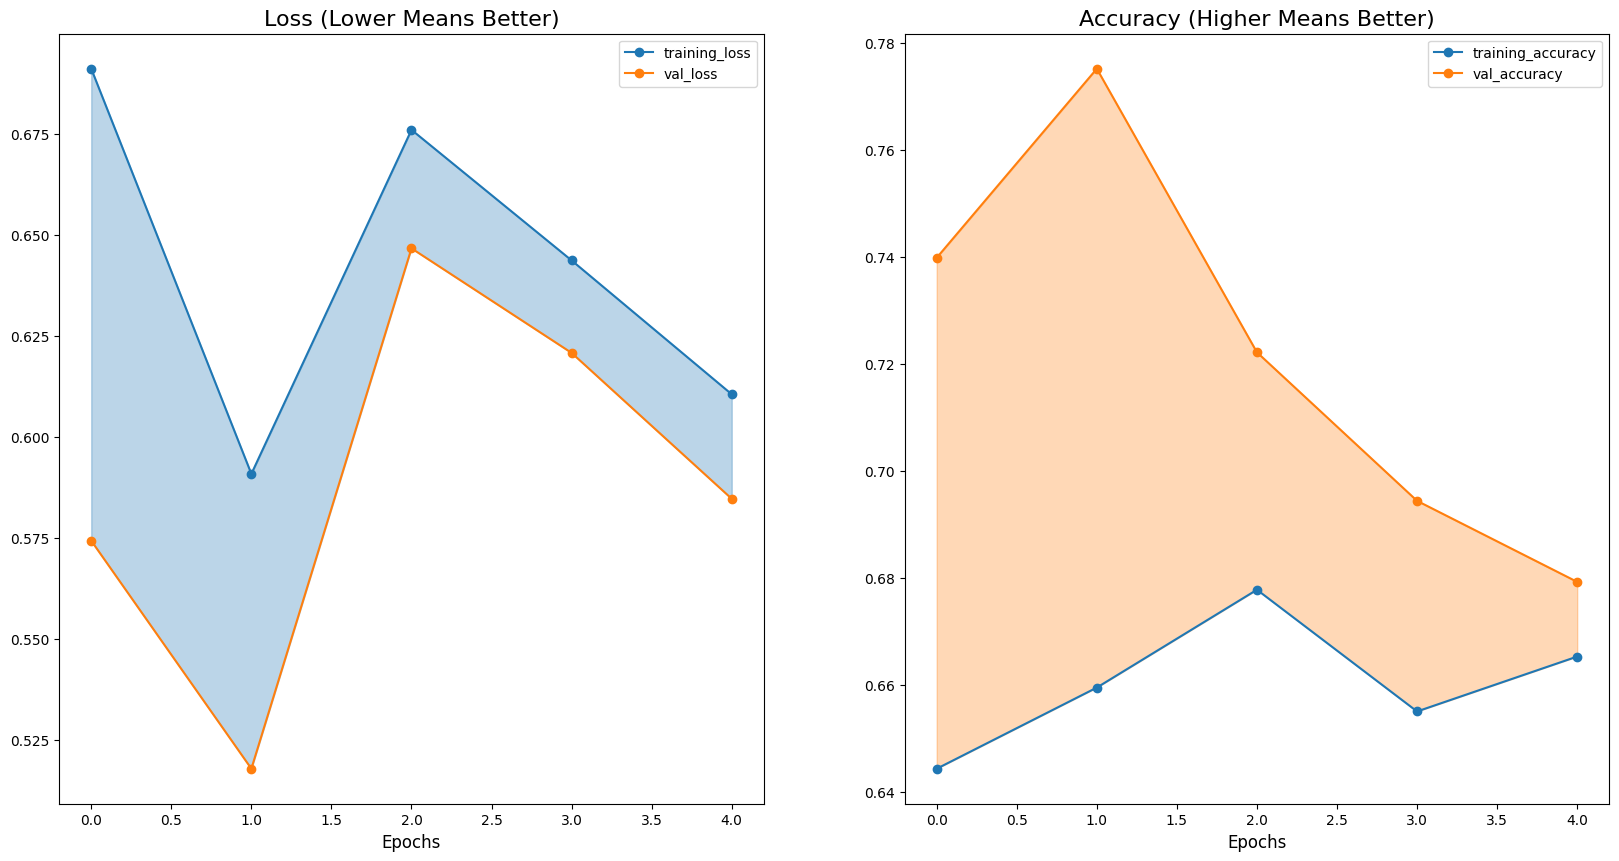

In [36]:
# plot cnn model training history 
plot_training_curves(cnn_history)

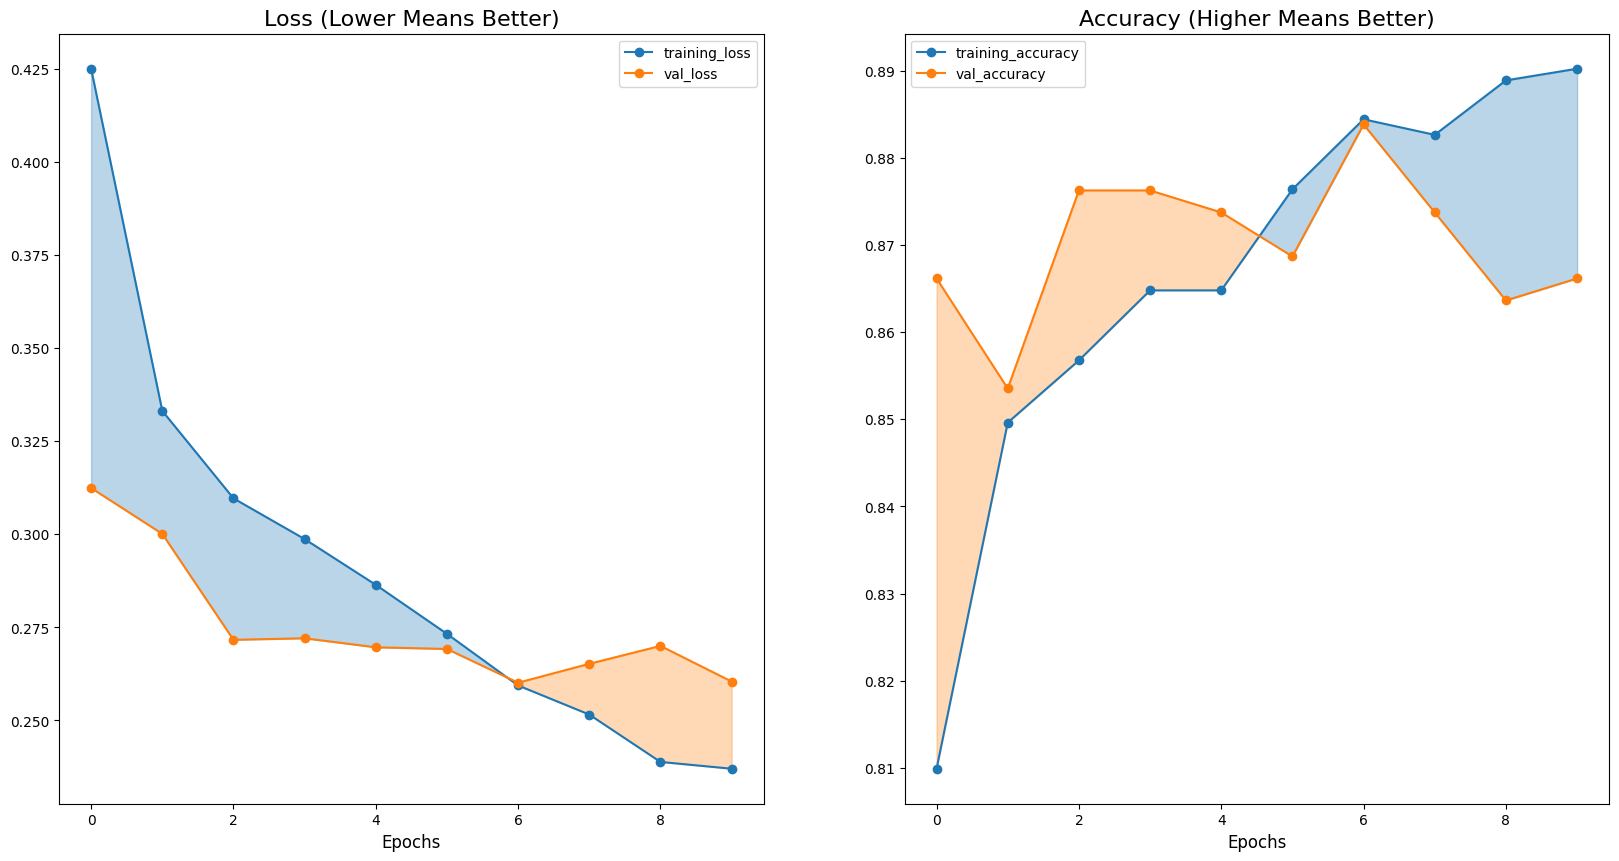

In [37]:
# Plot VIT B16 model training history 
plot_training_curves(vit_b16_history)


Confusion Matrix

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

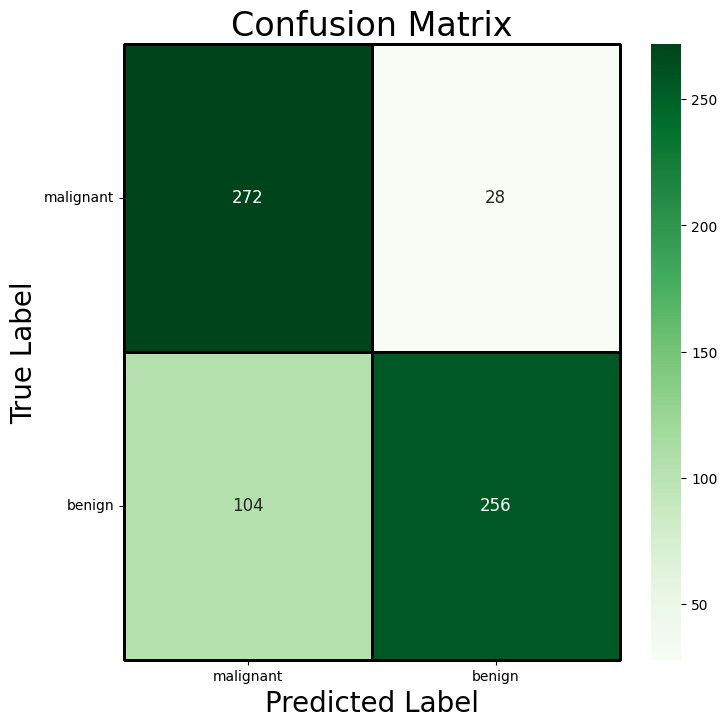

In [39]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(
    test_df.label_encoded, 
    cnn_test_predictions, 
    figsize=(8, 8), 
    classes=class_names)

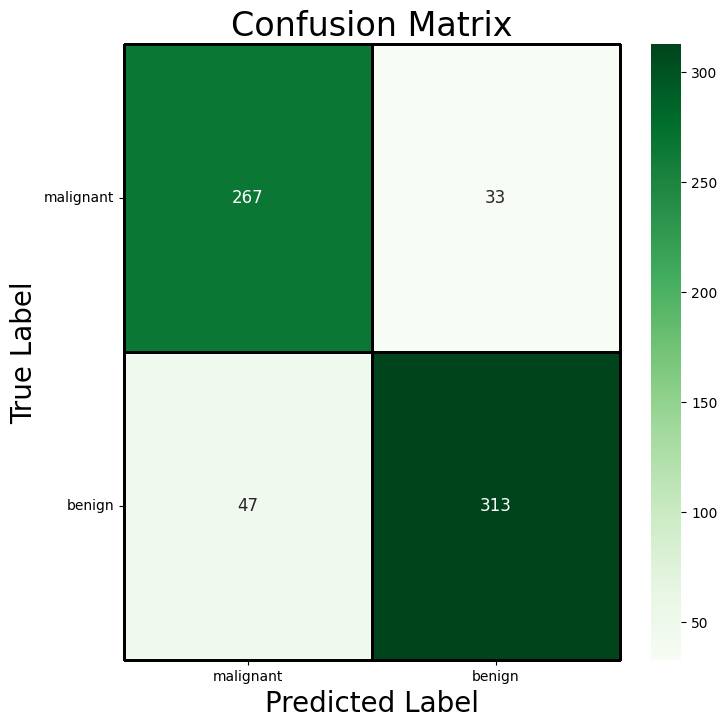

In [40]:
plot_confusion_matrix(
    test_df.label_encoded, 
    vit_b16_test_predictions, 
    figsize=(8, 8), 
    classes=class_names)